In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import cv2
from google.colab.patches import cv2_imshow
import glob
import os
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
path = xxx
all_images = glob.glob("/path/*.png")
all_images = [x[39:46] for x in all_images]
print('Number all images:', len(all_images))

Number all images: 30


In [ ]:
all_labels = glob.glob("/path/*.png")
all_labels = [x[39:46] for x in all_labels]
print('Number all labels:', len(all_labels))

Number all labels: 25


In [ ]:
train_images = [x for x in all_images if x in all_labels]
test_images = np.setdiff1d(all_images,train_images)
#Check if all the labels are within the train images
set(all_labels) == set(train_images)

True

In [ ]:
#Remove image '278.png' from data set since labels seem not to be correct
train_images.remove('278.png')

In [ ]:
#Unpack training images and labels
train_images_x = []
train_images_y = []

for image in train_images: 
  os.chdir('/path/')
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  train_images_x.append(img)

  os.chdir('/path/')
  img_y = cv2.imread(image)
  gray_image = cv2.cvtColor(img_y, cv2.COLOR_BGR2GRAY)
  image_black_white = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  train_images_y.append(image_black_white)

train_images_x = np.array(train_images_x)
train_images_y = np.array(train_images_y)

In [ ]:
ratio_white_pixel = []
for i in range(0, len(train_images_y)): 
  ratio = len(np.where(train_images_y[i] == 255)[0])/len(np.where(train_images_y[i] == 0)[0])
  ratio_white_pixel.append(ratio)

In [ ]:
#Imbalance between White and Black pixels in label image
ratio_white_pixel

[0.1600523949445959,
 0.1367121101744892,
 0.08851130267244672,
 0.13456711043401484,
 0.20559234731420162,
 0.12012032542558283,
 0.20013917629607925,
 0.12954153740089625,
 0.1525447574830291,
 0.14611496825868733,
 0.2601138286417474,
 0.19293008355024846,
 0.16872046366473473,
 0.11398946115927248,
 0.14210031020180544,
 0.17330277857347465,
 0.10557036337258342,
 0.14621519518679166,
 0.24380337825014234,
 0.05619752131380038,
 0.17053654354504535,
 0.3833748469624689,
 0.20256160889590252,
 0.15622519009897495]

In [ ]:
#Unpack test images
test_images_x = []
os.chdir('/path/')
for image in test_images: 
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_images_x.append(img)
test_images_x = np.array(test_images_x)

In [ ]:
#Split training images into training and validation set - 15% into validation set - shuffle data set
from sklearn.model_selection import train_test_split
train_images_x, validation_images_x, train_images_y, validation_images_y = train_test_split(train_images_x, train_images_y, test_size=0.15, random_state = 0, shuffle = True)

In [ ]:
#Transform pixel values in label images into 0 and 1
validation_images_y = np.where(validation_images_y == 255,1,0)

In [ ]:
#Augment training set - image and mask
train_images_y = np.expand_dims(train_images_y, 3)
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                     horizontal_flip=True,
                     vertical_flip=True#, 
                     #preprocessing_function = lambda x: x/255.
                     )

mask_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                     horizontal_flip=True,
                     vertical_flip=True,
                     preprocessing_function = lambda x: np.where(x== 255, 1, 0)) 

img_data_gen.fit(train_images_x, augment=True, seed=seed)
image_generator = img_data_gen.flow(train_images_x, seed=seed, batch_size = len(train_images_x))

mask_data_gen.fit(train_images_y, augment=True, seed=seed)
mask_generator = mask_data_gen.flow(train_images_y, seed=seed, batch_size = len(train_images_x))

def image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

generator = image_mask_generator(image_generator, mask_generator)

# **Model: UNet with ResNet50 as Encoder and pretrained ImageNet weights**

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    #Upsampling through transposed convolutions
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    #Concatenate upsampled input with input from encoder skip connections 
    x = Concatenate()([x, skip_features])
    #Apply convolutions on concatenated input
    x = conv_block(x, num_filters)
    return x

In [ ]:
#Build Model 
input_shape = (256, 256, 3)
inputs = Input(input_shape)

#Use pretrained ResNet50 Model with ImageNet weights as Encoder
resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
   
#Get Encoder skip connections
s1 = resnet50.get_layer(resnet50.layers[0]._name).output  ## (256 x 256)
s2 = resnet50.get_layer("conv1_relu").output        ## (128 x 128)
s3 = resnet50.get_layer("conv2_block3_out").output  ## (64 x 64)
s4 = resnet50.get_layer("conv3_block4_out").output  ## (32 x 32)

#Bridge
b1 = resnet50.get_layer("conv4_block6_out").output  ## (16 x 16)

#Decoder
d1 = decoder_block(b1, s4, 512)                     ## (32 x 32)
d2 = decoder_block(d1, s3, 256)                     ## (64 x 64)
d3 = decoder_block(d2, s2, 128)                     ## (128 x 128)
d4 = decoder_block(d3, s1, 64)                      ## (256 x 256)

#Output
outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

model = Model(inputs, outputs)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#Dice loss instead of binary cross entropy loss due to class imbalance
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  intersection_2 = 2 * tf.reduce_sum(y_true * y_pred)
  union_intersection = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

In [ ]:
#Use custom mean IoU metric because keras built in IoU metric does not consider a threshold
def mean_iou(y_true, y_pred):
  y_pred = tf.cast(tf.round(y_pred), tf.float32)
  y_true = tf.cast(y_true, tf.float32)
  intersect = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true + y_pred)
  return (intersect) / (union - intersect)

In [ ]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[mean_iou])

In [ ]:
filepath = '/gdrive/My Drive/dida_test_task/model/ResNet_segmentation_model.hdf5'
#Save model with lowest validation loss
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
            monitor='val_loss', verbose=0, save_best_only=True, mode='min')]

In [ ]:
#Use total size of training images as batch size - Full Batch Gradient Descent
BATCH_SIZE = len(train_images_x)
NUM_EPOCHS = 300

In [ ]:
segmentation_model = model.fit(generator, validation_data=(validation_images_x, validation_images_y), steps_per_epoch=1,
                                                 epochs=NUM_EPOCHS, callbacks = [callbacks])

Epoch 1/300
1/1 [==============================] - 58s 58s/step - loss: 0.8301 - mean_iou: 0.0701 - val_loss: 0.7068 - val_mean_iou: 0.1671


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
1/1 [==============================] - 2s 2s/step - loss: 0.7636 - mean_iou: 0.1452 - val_loss: 0.7093 - val_mean_iou: 0.1655
Epoch 3/300
1/1 [==============================] - 2s 2s/step - loss: 0.7240 - mean_iou: 0.1643 - val_loss: 0.7130 - val_mean_iou: 0.1653
Epoch 4/300
1/1 [==============================] - 2s 2s/step - loss: 0.7003 - mean_iou: 0.1802 - val_loss: 0.7158 - val_mean_iou: 0.1653
Epoch 5/300
1/1 [==============================] - 2s 2s/step - loss: 0.6705 - mean_iou: 0.2070 - val_loss: 0.7163 - val_mean_iou: 0.1653
Epoch 6/300
1/1 [==============================] - 2s 2s/step - loss: 0.6398 - mean_iou: 0.2358 - val_loss: 0.7164 - val_mean_iou: 0.1653
Epoch 7/300
1/1 [==============================] - 2s 2s/step - loss: 0.6007 - mean_iou: 0.2784 - val_loss: 0.7164 - val_mean_iou: 0.1653
Epoch 8/300
1/1 [==============================] - 2s 2s/step - loss: 0.5701 - mean_iou: 0.3174 - val_loss: 0.7164 - val_mean_iou: 0.1653
Epoch 9/300
1/1 [=================

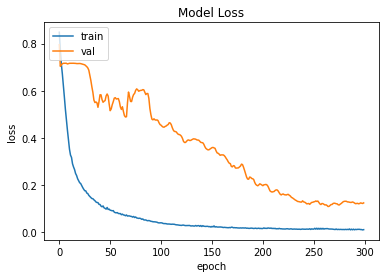

In [ ]:
import matplotlib.pyplot as plt
plt.plot(segmentation_model.history['loss'])
plt.plot(segmentation_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Test Model**

In [ ]:
segmentation_model = tf.keras.models.load_model(filepath, compile=False)

In [ ]:
test_predictions = segmentation_model.predict(test_images_x, verbose = 1)

1/1 [==============================] - 5s 5s/step


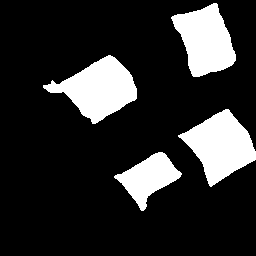

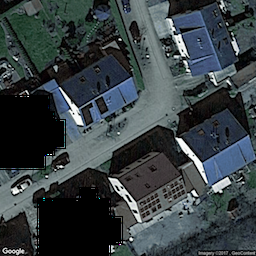

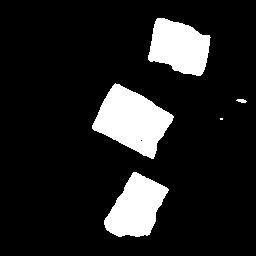

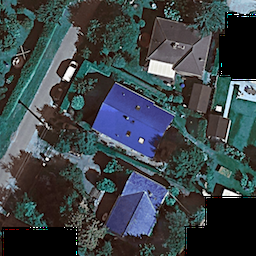

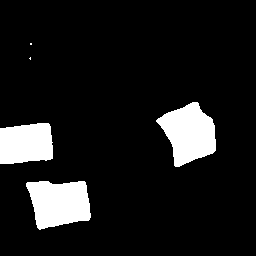

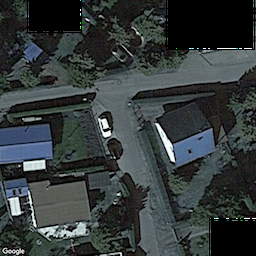

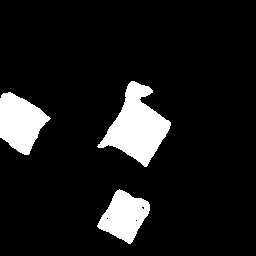

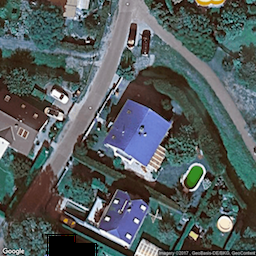

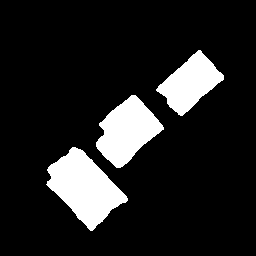

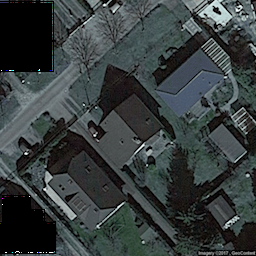

In [ ]:
from PIL import Image

os.chdir('/path')
test_predictions_image = np.where(test_predictions > 0.5,255,0)
for i in range(0, len(test_predictions_image)): 
  cv2_imshow(test_predictions_image[i])
  cv2.imwrite("test" + test_images[i], test_predictions_image[i])
  cv2_imshow(test_images_x[i])